# Image Approximation via Transparent Shape Evolution
---

**Student Informations**
|||
|---|---|
|*Student* | `Matteo Liotta`|
|*Student ID*| `SM3800072`|
|*Course*| *Optimisation for Artificial Intelligence, a.y. 2024/25, UniTS - Final Project*|

**Index**
|||
|-|---|
|**1**|<u>[***Original Problem***](#problem-introduction)</u>|
|> **1.1**| [*Problem Introduction*](#chosen-image)|
|> **1.2**| [*Chosen Image*](#chosen-image)|
|> **1.3**| [*Definition of individuals*](#definition-of-individuals-from-dna)|
|>> **1.3.1**| [*Main idea behind the individuals*](#main-idea)|
|>> **1.3.2**| [*Shape generation*](#shape-generations)|
|>> **1.3.3**| [*Strain individuals class*](#main-idea)|
|||
|**2**|<u>***[Multiprocessing and patches improvements](#models)***</u>|
|> **2.1**| [*Patching*](#1-patching) |
|> **2.2**| [*Fitness revisited*](#2-fitness-function-simplification-with-numpy) |
|> **2.3**| [*Evolution*](#3-evolution) |
|||
|**2**|<u>***[Conclusion](#conclusion-and-further-analysis)***</u>|


> **Additional references**
>
> [1] Vincent van Gogh - The Yorck Project (2002) 10.000 Meisterwerke der Malerei (DVD-ROM), distributed by DIRECTMEDIA Publishing GmbH. ISBN: 3936122202., Pubblico dominio, https://commons.wikimedia.org/w/index.php?curid=151972

---

## Original Problem

### Problem introduction

This code is the analysis of "Genetic-lisa", a project from Peter Braden, which aims to **recreate images** with genetic algorithms. The base concept is to **evolve** an image, as overlapping shapes using **mutation, natural selection and crossover** in order to reach similitude with the original picture. The project had different implementations over time, from Python to C, with different optimisations in order to both make it better on the computational side and evolution itself. The fitness function is based on the **pixel difference (for each channel).

In [ ]:
from PIL import Image, ImageDraw
import aggdraw, random
import copy
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import os
import shutil
from tqdm import trange
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML
import io
import base64
from tqdm.notebook import tqdm

In [1128]:
reduce_ratio = 12
REFERENCE = Image.open('references/parisimage.JPG').resize((2048//reduce_ratio, 3072//reduce_ratio))
REFERENCE_DATA = list(REFERENCE.getdata())
REFERENCE = REFERENCE.convert("RGB").quantize(colors=128)

IMAGE_SIZE = REFERENCE.size

### Chosen Image 

In this implementation, the idea is to select an image and try to recreate it from scratch.

(170, 256)


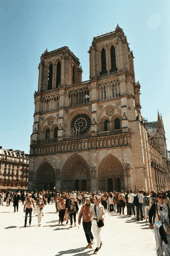

In [28]:
print(IMAGE_SIZE)
REFERENCE

> [1] By Vincent van Gogh - The Yorck Project (2002) 10.000 Meisterwerke der Malerei (DVD-ROM), distributed by DIRECTMEDIA Publishing GmbH. ISBN: 3936122202., Pubblico dominio, https://commons.wikimedia.org/w/index.php?curid=151972

### Definition of individuals from dna

The idea behind the population of interest, which is also explained in details in the code. The idea, however, to have individuals with a genome dna of shapes. 
The shape generation is possible thanks to the draw function.

#### Shape generations

Firstly, we have to consider the shapes generating functions, which are responsible for the definition of the shapes that will be present inside the image itself. We can consider in particular
* Ellipses
* Rectangles and Squares
* Triangles

In [1129]:
SHAPE_REDUCTION_RATE = 10


def generate_ellipse():
    # generate two random numbers, which at maximum could be
    # as big as the image width (x) and height (y). 
    x = random.randint(0, IMAGE_SIZE[0])
    y = random.randint(0, IMAGE_SIZE[1])

    x_half_bound = IMAGE_SIZE[0] // 2
    y_half_bound = IMAGE_SIZE[1] // 2

    # Then the image width and image height
    max_w = IMAGE_SIZE[0] // SHAPE_REDUCTION_RATE
    max_h = IMAGE_SIZE[1] // SHAPE_REDUCTION_RATE

    w = random.randint(5, max_w)
    h = random.randint(5, max_h)

    # Calculate bounds
    xs = min(x, IMAGE_SIZE[0])       # left (the x)
    xr = min(x + w, IMAGE_SIZE[0])   # right (the x+w)
    yu = min(y, IMAGE_SIZE[1])       # up (the y)
    yd = min(y + h, IMAGE_SIZE[1])   # down (the y + h)

    if x > x_half_bound:
        x1 = max(x - w, 0)
        x2 = x
    else:
        x1 = x
        x2 = min(x + w, IMAGE_SIZE[0])

    if y > y_half_bound:
        y1 = max(y - h, 0)
        y2 = y
    else:
        y1 = y
        y2 = min(y + h, IMAGE_SIZE[1])

    # Return ellipse as (left, top, right, bottom)
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])

    return "ellipse", [x1, y1, x2, y2]

def generate_rectangle():
    x = random.randint(0, IMAGE_SIZE[0])
    y = random.randint(0, IMAGE_SIZE[1])
    w = random.randint(0, IMAGE_SIZE[0])
    h = random.randint(0, IMAGE_SIZE[1])

    x_half_bound = IMAGE_SIZE[0]//2
    y_half_bound = IMAGE_SIZE[1]//2

    # Calculate bounds
    max_w = IMAGE_SIZE[0] // SHAPE_REDUCTION_RATE
    max_h = IMAGE_SIZE[1] // SHAPE_REDUCTION_RATE

    w = random.randint(5, max_w)
    h = random.randint(5, max_h)

    if x > x_half_bound:
        x1 = max(x - w, 0)
        x2 = x
    else:
        x1 = x
        x2 = min(x + w, IMAGE_SIZE[0])

    if y > y_half_bound:
        y1 = max(y - h, 0)
        y2 = y
    else:
        y1 = y
        y2 = min(y + h, IMAGE_SIZE[1])

    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])

    return "rectangle", [x1, y1, x2, y2]

def generate_triangle():
    points = []
    x_half_bound = IMAGE_SIZE[0] // 2
    y_half_bound = IMAGE_SIZE[1] // 2

    # Center
    cx = random.randint(0, IMAGE_SIZE[0])
    cy = random.randint(0, IMAGE_SIZE[1])

    max_dx = IMAGE_SIZE[0] // SHAPE_REDUCTION_RATE
    max_dy = IMAGE_SIZE[1] // SHAPE_REDUCTION_RATE

    for _ in range(3):
        dx = random.randint(-max_dx, max_dx)
        dy = random.randint(-max_dy, max_dy)

        px = min(max(cx + dx, 0), IMAGE_SIZE[0])
        py = min(max(cy + dy, 0), IMAGE_SIZE[1])

        points.extend([px, py])

    return "triangle", points

After that, since we're considering semi-transparent shapes for a colored images, we need to define a function that is capable of generating the color of shapes. It's important to point out that this function behaves acrodingly to the fact we have a previous color:
* If it's the first time in which we're generating a color, the original python code puts **no** restriction to the color we could sample, even if it could be a disadvantage in the long term due to eccessive need of correction
* If there is already a shape we're considering -i.e. in a mutation phase- we can decide to **change** it's color, but the change occurs just around the original color.

In [1131]:

def generate_color(prev = None, a_mutation = (-0x5,0x3), rgb_mutation = (-0x5,0x3)):
	# Wheter the previous color is passed, the result will be
	# - The previous with a random variation within a limited scale 
	# - A new randomic color 
	if prev:
		# the change range wrt the previous is +-3 for the color red channel 
		# and +- 5 for color tonality and transparency
		return (prev[0] + random.randint(*a_mutation),  # R
		  	    prev[1] + random.randint(*rgb_mutation),  # G
				prev[2] + random.randint(*rgb_mutation),  # B
				prev[3] + random.randint(*rgb_mutation))  # A
	
	return (random.randint(0x33, 0x99),  # R: between 51 and 153 -> this limits red colors to the excess
		    random.randint(0, 0xff),     # G: between 0 and 255
			random.randint(0, 0xff),     # B: between 0 and 255
			random.randint(0, 0xff))     # A: between 0 and 255


In [1187]:
def example_color_mutation(a_mutation = (-0x5,0x3), rgb_mutation = (-0x5,0x3)):
    example_color = generate_color()
    mutated_colors = []

    for i in range(10):
        mutated_color = generate_color(example_color, a_mutation, rgb_mutation)
        mutated_colors.append(mutated_color)

    colors_to_plot = [example_color] + mutated_colors
    colors_to_plot = [[i / 255 for i in j] for j in colors_to_plot]

    fig, ax = plt.subplots(1, 11, figsize=(12, 1.5))
    #fig.patch.set_facecolor((14/255, 17/255, 22/255))
    ax[0].set_title("Original")#, color = "white")
    for i, color in enumerate(colors_to_plot):
        ax[i].imshow([[color]])
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

So we can see...

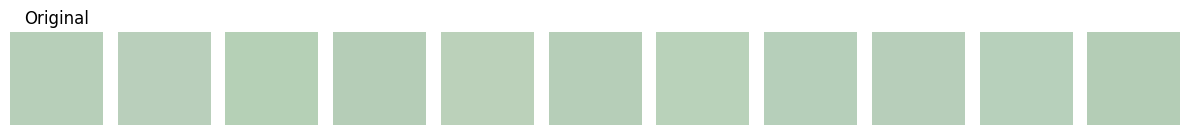

In [1141]:
example_color_mutation()

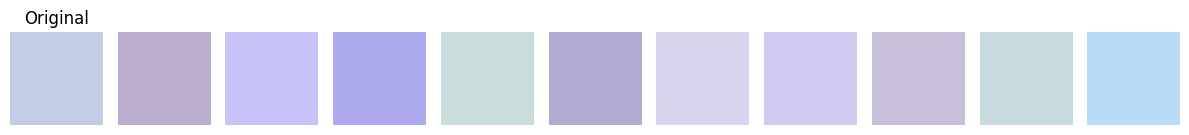

In [1188]:
example_color_mutation(a_mutation = (-0,0), rgb_mutation = (-50,50))

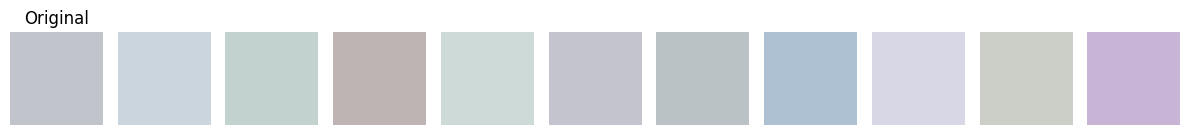

In [ ]:
example_color_mutation(a_mutation = (-30,A30), rgb_mutation = (-40,40))

But the idea is to permit also squares ad trinangles

In [35]:
def generate_shape(
                    func_list = [generate_ellipse, generate_rectangle, generate_triangle],
                  ):
    
    # extract randomly a shape to do
    generator_shape = random.choice(func_list)
    shape_type, coords = generator_shape()
    
    return {'type': shape_type, 'coords': coords}

The images generation behaves as this:

In [36]:
def draw_shape(shape, size=(200, 200)):
    image = Image.new("RGBA", size, (255, 255, 255, 255))
    draw = aggdraw.Draw(image)
    brush = aggdraw.Brush("blue")

    if shape['type'] == 'ellipse':
        draw.ellipse(shape['coords'], brush)
    elif shape['type'] == 'rectangle':
        draw.rectangle(shape['coords'], brush)
    elif shape['type'] == 'triangle':
        # coords come come lista [x1, y1, x2, y2, x3, y3]
        draw.polygon(shape['coords'], brush)

    draw.flush()
    display(image)

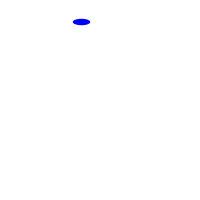

{'type': 'ellipse', 'coords': [73, 19, 90, 25]}

In [37]:
shape = generate_shape()
draw_shape(shape)
shape

In [38]:
print(IMAGE_SIZE)
shape

(170, 256)


{'type': 'ellipse', 'coords': [73, 19, 90, 25]}

> ### <u>**Important Change**</u>: Parametrized shape change
>
> The problem here with the original code is that, despite what we did for the color, **shapes can only be re-generated from scratch, since the generating function in the original code didn't provide a way to change their coordinates, eventually. The idea here was to add this small detail that could be used.
> It's only important to see here that we can give each function the previous shape and generate **w.r.t. the previous one**, by changing the others.

To be coherent with the previous observation, let's change the function originally defined as follows
* A parameter changes the position of each edge

In [39]:
def generate_shape(
                    func_list = [generate_ellipse, generate_rectangle, generate_triangle],
                    prev = None,
                    position_change_min_max = (-5,5)
                  ):
    
    if prev == None:
        # extract randomly a shape to do
        generator_shape = random.choice(func_list)
        shape_type, coords = generator_shape()
        
        return {'type': shape_type, 'coords': coords}

    else:
        # Just change the position if the previous shape is given
        prev["coords"] = [i + random.randint(*position_change_min_max) for i in prev["coords"]]
        return prev

So, an example...

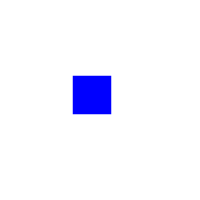

In [40]:
SHAPE_REDUCTION_RATE = 4
shape = generate_shape()
draw_shape(shape)

In [41]:
shape

{'type': 'rectangle', 'coords': [73, 76, 111, 114]}

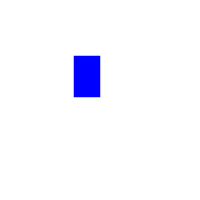

In [42]:
draw_shape(generate_shape(prev=shape, position_change_min_max=(-20,20)))

> **Recap:**
> 
> - We have function that defines shapes and colors
> - These function can (or we can avoid it) receive the previous and modify it within a radius
>   - Parameters here are `position_change_min_max` for shapes
>   - `a_mutation` and `rgb_mutation` for colors
>
> These were not present in the original python file, but these are characteristics we can eventually use or not

#### Strain individuals

Explanation

> ### <u>**Important Change**</u>: Parametrized shape change and color used
>
> As said before, in the original code in the case of CHANGE mutation (which was not a ADD or REMOVE action), the behavior was about:
> 1. removing randomly a shape
> 2. generating a new shape (from zero)
> 3. adding it to the dna instead of the other (appended)
>
> But then, of course, since the CHANGE would be just a new generation, we cannot take advantage of eventual previous knowledge! In fact, the idea is to change shapes in this way
> 1. removing randomly a shape (as before)
> 2. Instead of generating from zero, generate with the prev argument defined above
>
> In this case the change is actually performing a slightly change in the color of the shape and a change in the shape itself (e.g. position, edges moved a bit)

> Another change is the dimension parameter of shapes: smaller shapes means higher accuracy shape reproduction

In [43]:
class Strain(object):

	'''
	This class generates individuals with their own dna, name and parents. The idea is
	to provide each individuals with their dna, which is an actual list of shapes to be applied
	in the canvas. 

	The dna of a Strain object is an actual list of shapes as:

		[ ... , {'shape': {'type': 'rectangle', 'coords': [221, 62, 348, 172]}, 'color': (137, 116, 58, 225)}, ... ]

	'''	

	### INDIVIDUAL DEFINITION
	def __init__(self, 
			  	 name = None, # something like "genXX-N"
				 dna_string =  None, 
				 parents = None
				 ):
		
		self._fitness = None

		### If a dna string is given as input

		if dna_string: 
			d = dna_string
			self.dna = d['dna'] # save it
			self.name = d['name']
			self._fitness = d.get('fitness')

		### Otherwise if WE HAVE parents...

		elif parents: # Breed randomly from parents
			
			# If no string is givem we can copy the dna of parents and
			# we can apply mutation over it and crossover. 

			self.dna = copy.deepcopy(random.choice(parents).dna) # copy parents dna
			self.name = name # use this name
	
			# then apply the mutation: 
			# - if the random number (between 0 and 1 uniformly) is over 0.2 
			# - or if the dna length is not so elevated (so for short DNAs we "force" mutation
			#   to avoid same-dnas)
			if random.random() > 0.2 or len(self.dna)<20:
				self.mutate() # apply mutation
			
			# Now we need to do the CROSSOVER, but it makes sense only if the
			# individuals are not an empty list:
			
			if self.dna: # equivalent to "if self.dna != []:"

				for i in range(random.randint(1, len(parents))): # for each element of the dna string
					# Randomly extract a shape from the a parent dna.
					x = random.choice(parents).dna 
					
					y = x and random.choice(x) 
					# In y, since the x is a entire dna list and the other is an extracted shape, the result will be
					# - the specific extracted if it's not []
					# - [] otherwise

					# So, if the y is an actual gene and not a [], we need to produce an
					# independent copy of that gene
					y = y and copy.deepcopy(y)
					
					# then we extract an index number to point in the current individual 
					# dna and... if its [] the gene remains the same, while otherwise it's 
					# changed with the other above.
					z = random.randint(0,len(self.dna)-1)
					self.dna[z] = y or self.dna[z]
			
		### BUT if we do NOT have parents...
		else:
			self.name = name
			self.dna = [] # the dna is initialized together with the individual name.
		

	### MUTATION DEFINITION
	def mutate(self):
		# The numation is about changing the dna of the individuals

		x = random.random() # between 0 and 1, this will be analogous to mutation probability

		## ADD A SHAPE
		#  with a high (75%) probability or with a not extremely large genome, 
		#  we can add a new gene shape
		if x<0.25 and len(self.dna)<500: 
			# PREVIOUS: self.dna.append({'ellipse' : generate_ellipse(), 'color' : generate_color()})
			self.dna.append({'shape' : generate_shape(), 'color' : generate_color()})
		
		## CHANGE A SHAPE
		#  With the other 25% probability or with eventually big genomes we can 
		#  change a gene by popping randomly one of them.
		elif x<0.75: 
			# If the genome is too large 
			
			if self.dna: 
				# ... pop one 
				extracted_shape = self.dna.pop(random.randint(0,len(self.dna)-1))
				
				self.dna.append({'shape' : generate_shape(prev = extracted_shape["shape"], position_change_min_max=(-10,10)), 
								 'color' : generate_color(prev=extracted_shape["color"], a_mutation=(-30,30), rgb_mutation = (-40,40))})
				
			self.dna.append({'shape' : generate_shape(), 'color' : generate_color()}) # if no dna, no pop, just add

			## FASTEST alternative
			idx = random.randint(0, len(self.dna) - 1)
			self.dna[idx], self.dna[-1] = self.dna[-1], self.dna[idx]  # swap with last one
			self.dna.pop()

		## REMOVE A SHAPE
		#  This could only occur if the genome length is OVER max_length
		#  The maximum genome length is fixed.
		else:
			# or we can just pop
			if self.dna: self.dna.pop(random.randint(0,len(self.dna)-1))
		
		## RECURSIVE MUTATION
		#  Since otherwise the mutation would occur on just one gene, recursive mutation
		#  admit with low probability also the case of whole dna change (specifically in the 
		#  evolution beginning phase)
		if random.random()<0.1:
			self.mutate()
		
		# Since the genome has been changed, the previously computed fitness stored 
		# is no more valid and we need to re-evaluate it.
		self._fitness = None	

	
	## FITNESS EVALUATION functions

	def _pix_comp(self, ref, mut):
		# Used for pixel-pixel function evaluation... 
		r = ref[0] - mut[0]
		g = ref[1] - mut[1]
		b = ref[2] - mut[2]
		return r*r + g*g + b*b


	def fitness(self):
		return self._fitness or self._fitness_func()


	def _fitness_func(self):
		"""
			Compare strain against reference image.
		"""
		
		fitness = 0
		mut = iter(REFERENCE_DATA)
		for i in self.draw().getdata():
			j = next(mut)
			fitness += self._pix_comp(i, j) # we add the pixel to pixel matching differences 
		
		self._fitness = fitness	
		return fitness

	def _numpy_fitness_func(self):
		''' 
		Compare the collection of shapes drawing obtained after rendering
		with the reference image. This new implementation avoids for cycles 
		to take advantage of numpy library speed.

		As before, the idea is to use the sum of squares of the difference over all channels
		as a measure.
		'''
		
		# IMG APPROX (not used)
		#size = tuple([s//4 for s in REFERENCE.size])
		#img = self.draw().resize(size).convert('RGBA')
		#ref = REFERENCE.resize(size).convert('RGBA')
		
		# img = self.draw().convert('RGBA')
		# ref = REFERENCE.convert('RGBA')
		ref = np.array(REFERENCE_DATA)[:, :3]  # solo RGB
		img = np.array(list(self.draw().getdata()))[:, :3]
		
		# Converte in array e flattens in (N, 3) per RGB
		# img_array = np.array(img)
		# ref_array = np.array(ref)

		# Differenza e somma dei quadrati (come _pix_comp per ogni pixel)
		#diff = img_array - ref_array
		diff = img - ref

		squared_diff = diff ** 2
		fitness = np.sum(np.sum(squared_diff,axis=0))

		self._fitness = int(fitness)
		return self._fitness
	

	## IMAGE-SHAPE DRAWING
	def draw(self):
		img = Image.new('RGBA', IMAGE_SIZE, (0, 0, 0, 0))  # canvas vuoto
		draw = aggdraw.Draw(img)

		for poly in self.dna:
			# in the dna are contained different shape informations we use
			# to fill the defined canvas

			shape = poly['shape'] # the shape name
			brush = aggdraw.Brush(poly['color'])

			# It clearly depends on the shapes the individual receives in the dna.
			# We can handle different cases, but they must be present in the global 
			# function defined for shape generation: generate_shape()
			
			if shape['type'] == 'ellipse':
				draw.ellipse(shape['coords'], brush)

			elif shape['type'] == 'rectangle':
				draw.rectangle(shape['coords'], brush)

			elif shape['type'] == 'triangle':
				draw.polygon(shape['coords'], brush)

		draw.flush()
		return img
	
	## Individual representation
	def __repr__(self):
		d = {'name' : self.name, 'dna' : self.dna}
		if self._fitness:
			d['fitness'] = self._fitness
		return repr(d)


Explain what has been modified

### Start generation process

First of all we have to select the parameters for the evolution

In [44]:
MAX_GENERATIONS = 10
GENERATION_POPULATION = 10
CROSSOVER_POPULATION = 5
INITIAL_GENERATION = 10

And initialize the population

In [45]:
initial_data  = [Strain(name = 'initial') for x in range(CROSSOVER_POPULATION)]
i = 0
epoch = 0

or we can recover a previously evolved population

In [46]:
def recover_population(path, INITIAL_GENERATION):
    try:
        path = f"{path}/gen-{INITIAL_GENERATION}.txt"
        with open(path, "r") as f:
            content = f.read()

        # recover data from the txt file saved to start with previously evolved population.
        namespace = {}
        exec(content, {}, namespace)
        initial_data = [Strain(dna_string=x) for x in namespace['initial_data']]
        return initial_data

    except Exception as e:
        print("An error occurred...", e)


INITIAL_GENERATION = 8400
i = INITIAL_GENERATION
initial_data = recover_population("results/full", INITIAL_GENERATION)
epoch = 0

# So, the difference is that we could choose to train another 100 times, with an elevated "i"
# without changing the number of MAX_GENERATIONS at i + 100.

Then we can start with the evolution.

In [ ]:

def evolution(image_save_path = "results/full", 
              initial_data = [Strain(name = 'initial') for x in range(CROSSOVER_POPULATION)], 
              MAX_GENERATIONS = MAX_GENERATIONS,
              i = 0, 
              starting_fitnesses = [],
              epoch = 0):
    
    best = 999999999999999999
    fitnesses = copy.copy(starting_fitnesses) # keep the fitness for each epoch
    crossover_strains = initial_data
    last_img = best
    last_best_epoch = 0

    pbar = tqdm(total=MAX_GENERATIONS, desc="Evolution")
    
    while epoch < MAX_GENERATIONS:
        i += 1
        epoch += 1 # same as i 
        

        ### GENERATION 

        generation = []
        for j in range(GENERATION_POPULATION): 

            # Generate GENERATION_POPULATION individuals obtained via 
            # mutation and crossover previously defined
            
            p = Strain(parents = crossover_strains, name = "gen%s-%s" % (i,j))
            generation.append(p)

        ### SELECTION
        # Keep previous best of breed:
        generation.extend(crossover_strains)
        generation.sort(key = lambda x: x.fitness())

        crossover_strains = generation[:CROSSOVER_POPULATION]
        best = crossover_strains[0].fitness()
        fitnesses.append(best)
        # del(generation)

        if i % 100 == 0: #best < last_img *0.8:
            last_img = best
            last_best_epoch = i
            
            crossover_strains[0].draw().convert("RGB").save(f"{image_save_path}/{crossover_strains[0].name}.png")
            save = open(f"{image_save_path}/gen-{i}.txt", "w")
            save.write("initial_data = " + repr(crossover_strains))
            save.close()
        
        pbar.update(1)
        pbar.set_postfix({"last_best_epoch": last_best_epoch, "epoch": epoch})
        
    pbar.close()   
    return fitnesses

In [47]:
recover_population("results/full", 200)

[{'name': 'gen197-4', 'dna': [{'shape': {'type': 'triangle', 'coords': [49, 122, 170, 76, 156, 5]}, 'color': (112, 222, 91, 246)}, {'shape': {'type': 'triangle', 'coords': [100, 137, 90, 48, 77, 84]}, 'color': (96, 245, 230, 237)}, {'shape': {'type': 'triangle', 'coords': [49, 122, 170, 76, 156, 5]}, 'color': (112, 222, 91, 246)}, {'shape': {'type': 'triangle', 'coords': [33, 46, 9, 209, -1, 11]}, 'color': (159, 230, 191, 190)}, {'shape': {'type': 'triangle', 'coords': [114, 64, 127, 250, 54, 144]}, 'color': (107, 160, 99, 106)}, {'shape': {'type': 'triangle', 'coords': [43, 57, 12, 205, 19, 25]}, 'color': (130, 237, 185, 214)}, {'shape': {'type': 'ellipse', 'coords': [26, 202, 60, 259]}, 'color': (139, 230, 111, 147)}, {'shape': {'type': 'triangle', 'coords': [137, 241, 15, 6, 112, 20]}, 'color': (123, 162, 5, 177)}, {'shape': {'type': 'triangle', 'coords': [33, 46, 9, 209, -1, 11]}, 'color': (159, 230, 191, 190)}, {'shape': {'type': 'ellipse', 'coords': [60, 227, 101, 247]}, 'color':

In [48]:
def clear_folder(path):

    folder = path
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

In [212]:
# Evolution
clear_folder("results/full")
fitnesses = evolution(image_save_path="results/full", MAX_GENERATIONS=1000)

Evolution:   0%|          | 0/1000 [00:00<?, ?it/s]

In [233]:
# and some more
INITIAL_GENERATION = 11200
fitnesses = evolution(i=INITIAL_GENERATION,
          epoch=0,
          starting_fitnesses=fitnesses,
          initial_data=recover_population("results/full", INITIAL_GENERATION),
          image_save_path="results/full", MAX_GENERATIONS=20000)

Evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

> 30000 epoche in 1 ora e mezza

##### Image evolution visualization

---

## Multiprocessing and Patches: code improvements

We saw that the procedure was, even with small changes in the fitness evaluation with numpy, very small.

(170, 256)


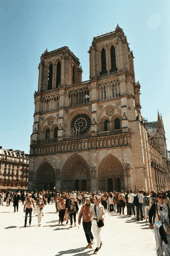

In [59]:
IMAGE_SIZE = REFERENCE.size

GENERATION_POPULATION = 10
CROSSOVER_POPULATION = 5

INITIAL_GENERATION = 10

print(IMAGE_SIZE)
REFERENCE

### 1. Patching

The idea is to divide the picture into patches and evolve them independently, to match them at the end reconstructing the image. 

In [60]:
def split_image_in_patches(image, rows, cols):
    # Split the image in a new collection of patches, by selecting the number of cuts
    # to do orizontally (row) and vertically (cols)    
    width, height = image.size
    patch_width = width // cols
    patch_height = height // rows

    patches = []
    idx = 0

    # Then we need coordinates to know where to cut patches
    for r in range(rows):
        for c in range(cols):
            left = c * patch_width
            upper = r * patch_height
            right = left + patch_width
            lower = upper + patch_height

            # So the current patch can be obtained cropping
            # and it's added to the collection, together with the reference (index)
            # to recover the full image at the end.
            patch_img = image.crop((left, upper, right, lower))
            patches.append({
                'index': idx,
                'row': r,
                'col': c,
                'pos': (left, upper),
                'patch': patch_img
            })
            idx += 1
    return patches

So we have

In [61]:
patches = split_image_in_patches(REFERENCE, 4, 2)


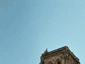
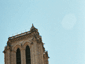
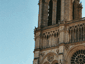
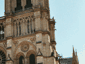
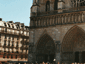
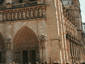
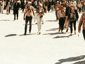
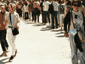

In [ ]:
def pil_image_to_base64(img):
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()

def display_patches_flex_wrap(patches, max_cols=4, img_height=100):
    patches = sorted(patches, key=lambda x: (x['row'], x['col']))

    max_width = max_cols * (img_height + 20)  # extra margin to make clear the division
    html = f'<div style="display: flex; flex-wrap: wrap; max-width: {max_width}px;">'
    for p in patches:
        img_b64 = pil_image_to_base64(p['patch'])
        html += f'<div style="margin: 5px;">'
        html += f'<img src="data:image/png;base64,{img_b64}" style="height:{img_height}px;">'
        html += '</div>'
    html += '</div>'
    display(HTML(html))

display_patches_flex_wrap(patches, max_cols=3, img_height=100)

### 2. Fitness function simplification (with numpy)

The idea is to simplify the function evaluation in order to speed up the evolution cycle and admit more epochs in far less time.

In [63]:
## Inside the Strain Class

def fitness(self):
	return self._fitness or self._fitness_func()    

def _fitness_func(self):
    ref_img = self.reference_image.convert("RGBA")
    draw_img = np.array(self.draw().convert("RGBA"), dtype=np.int16)
    ref_img = np.array(ref_img, dtype=np.int16)
    diff = draw_img[:, :, :3] - ref_img[:, :, :3]        
    fitness = np.sum(np.abs(diff))
    self._fitness = fitness
    return fitness

### 3. Evolution!

Select the number of threads to use

In [64]:
process_num = os.cpu_count()
print(os.cpu_count()) # core number

process_num = 8 # make same mac and intel pc folder

12


Clear patches folder and create folders `"img_generated_updates/patches/num_{thread}"`

In [507]:
path = "results/patches"

def clear_folder(path):

    folder = path
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

clear_folder(path)

In [ ]:
for process in range(process_num):
    folder_path = f"{path}/num_{process}"
    os.makedirs(folder_path, exist_ok=True)

Now, we know that the training is actually the same for each patch. Run this code to execute a python script in background.

In [484]:
### run the code for multiplrocessing start.
!python3 main_multiprocessing.py

(170, 256)
(170, 256)
(170, 256)
(170, 256)
(170, 256)
(170, 256)
Recovered patch 1 from generation 14000
Recovered patch 4 from generation 14000
Recovered patch 0 from generation 14000
(170, 256)
Recovered patch 2 from generation 14000
(170, 256)
Recovered patch 3 from generation 14000
Recovered patch 5 from generation 14000
(170, 256)
Recovered patch 6 from generation 14000
Recovered patch 7 from generation 14000
1895.4788620471954 seconds used


And then we reconstruct

In [ ]:
def reconstruct_epoch_from_patch_folders(epoch_number, patches, base_folder="results/patches", show=True):
    
    patch_w, patch_h = patches[0]['patch'].size
    
    total_width = max(p['pos'][0] for p in patches) + patch_w
    total_height = max(p['pos'][1] for p in patches) + patch_h
    final_img = Image.new("RGBA", (total_width, total_height), (0, 0, 0, 0))

    for p in sorted(patches, key=lambda x: (x['row'], x['col'])):
        patch_index = p['index']
        folder = os.path.join(base_folder, f"num_{patch_index}")

        filename = f"gen-{epoch_number}.png"
        filepath = os.path.join(folder, filename)

        patch_img = Image.open(filepath).convert("RGBA")
        final_img.paste(patch_img, p['pos'], patch_img)

    if show:
        display(final_img)

    return final_img

# reconstruct_epoch_from_patch_folders(1000, patches, base_folder=path)
# REFERENCE

## Conclusion and further analysis

### Other examples and the idea of epoch scheduling size

Remember that 
1. At the beginning it's important to learn big shapes
2. With evolution epochs increasing, it's important to add small details instead of random big ones. 

We could expect an improve reducing the parameter responsible for the shape size `SHAPE_REDUCTION_RATE` wrt `epochs`.
We can first consider the result on the case of small and high `SHAPE_REDUCTION_RATE` result with fixed epochs number of 10000.

In [137]:
image_path = "references/sunflower.jpg"
w = 192
h = 240
reduce_ratio = 1

REFERENCE = Image.open(image_path).resize((w//reduce_ratio, h//reduce_ratio))
REFERENCE_DATA = REFERENCE.getdata()
REFERENCE = REFERENCE.convert("RGB").quantize(colors=128)
IMAGE_SIZE = REFERENCE.size

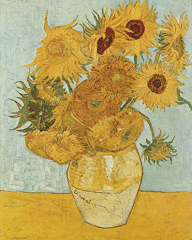

In [1114]:
#patches = split_image_in_patches(REFERENCE, rows=4, cols=2)
#display_patches_flex_wrap(patches, max_cols=4)
REFERENCE

In [ ]:
# IMAGE_NUMBER = 2 
# False recover
# NO SHAPE REDUCTION (1)
!python3 main_multiprocessing.py

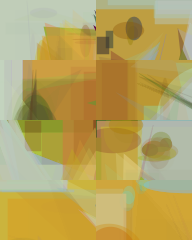

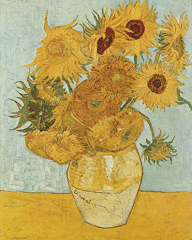

In [1011]:
reconstruct_epoch_from_patch_folders(10000, patches, base_folder="other_examples/sunflower")
REFERENCE

In [ ]:
# IMAGE_NUMBER = 2 
# False recover
# HIGH SHAPE REDUCTION (10)
!python3 main_multiprocessing.py

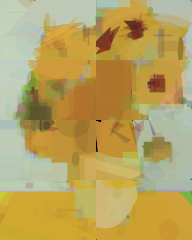

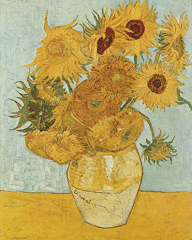

In [1117]:
reconstruct_epoch_from_patch_folders(10000, patches, base_folder="other_examples/sunflower")
REFERENCE

We clearly see a noticeable improvement in the image with a low value. We can eventually start with small ones.

In [ ]:
# IMAGE_NUMBER = 2 
# False recover
# HIGH SHAPE REDUCTION (30)
# total of 50000 epochs
# 12 patches
!python3 main_multiprocessing.py

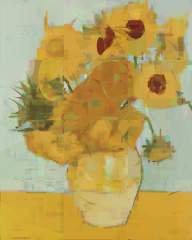

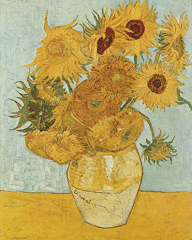

In [149]:
reconstruct_epoch_from_patch_folders(50000, patches, base_folder="other_examples/sunflower")
REFERENCE

---

The idea is not to end with a strong evolution on initial image, flowers and on the black and white one

In [65]:
image_path = "references/trieste.JPG"
w = 3130
h = 2075
reduce_ratio = 7

REFERENCE = Image.open(image_path).resize((w//reduce_ratio, h//reduce_ratio))
REFERENCE_DATA = REFERENCE.getdata()
REFERENCE = REFERENCE.convert("RGB").quantize(colors=128)
IMAGE_SIZE = REFERENCE.size


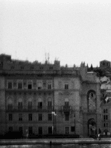
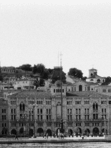
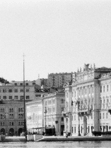
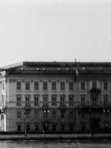
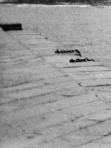
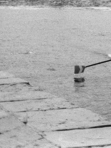
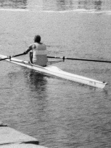
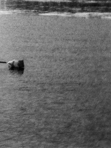

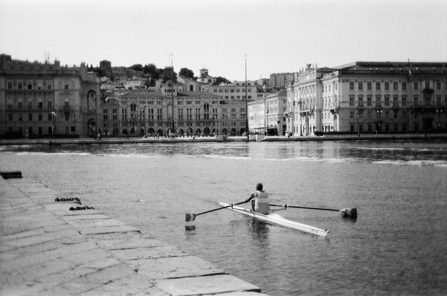

In [66]:
patches = split_image_in_patches(REFERENCE, rows=2, cols=4)
display_patches_flex_wrap(patches, max_cols=3)
REFERENCE

In [ ]:
# IMAGE_NUMBER = 3
!python3 main_multiprocessing.py

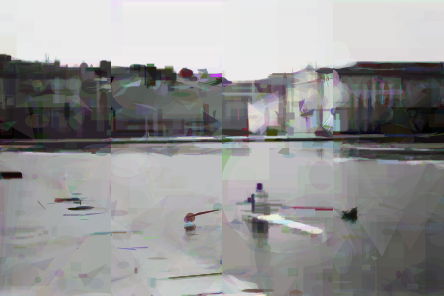

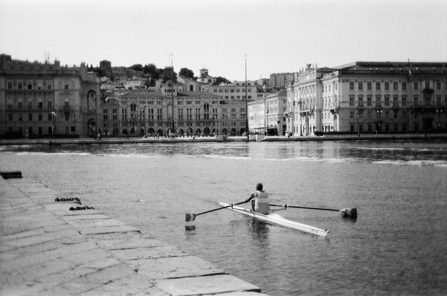

In [90]:
reconstruct_epoch_from_patch_folders(90000, patches, base_folder="other_examples/trieste")
REFERENCE

---

In [129]:
reduce_ratio = 8
REFERENCE = Image.open('references/parisimage.JPG').resize((2048//reduce_ratio, 3072//reduce_ratio))
REFERENCE_DATA = list(REFERENCE.getdata())
REFERENCE = REFERENCE.convert("RGB").quantize(colors=128)

IMAGE_SIZE = REFERENCE.size


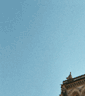
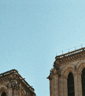
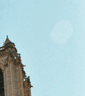
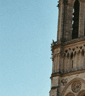
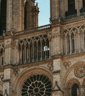
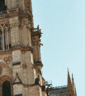
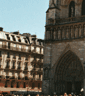
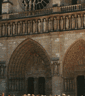
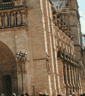
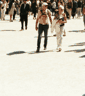
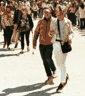
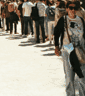

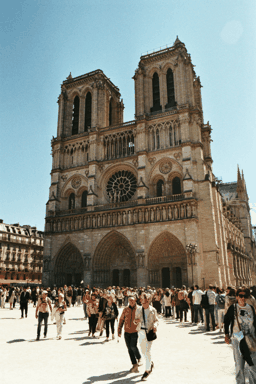

In [130]:
patches = split_image_in_patches(REFERENCE, rows=4, cols=3)
display_patches_flex_wrap(patches, max_cols=3)
REFERENCE

In [ ]:
# IMAGE_NUMBER = 4
!python3 main_multiprocessing.py

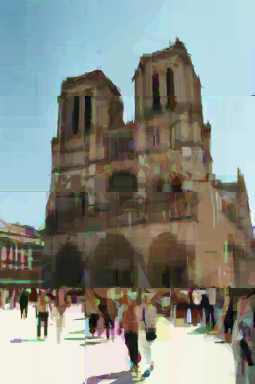

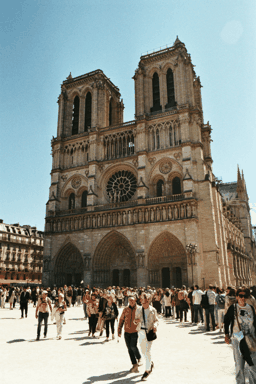

In [133]:
reconstruct_epoch_from_patch_folders(50000, patches, base_folder="other_examples/smallshapeparis")
REFERENCE

$\blacksquare$